In [ ]:
import os
import logging
from pathlib import Path

LOG_DIR = "../../logs"
os.makedirs(LOG_DIR, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(f"{LOG_DIR}/yolo_binary.log"),
        logging.StreamHandler(),
    ],
)

logger = logging.getLogger(__name__)
logger.info("Starting YOLOv8 binary road anomaly experiment")

2026-02-01 16:23:46,813 | INFO | Starting YOLOv8 binary road anomaly experiment


In [ ]:
# Original VOC dataset
DATA_ROOT = Path("../../India")
IMG_DIR = DATA_ROOT / "train" / "images"
XML_DIR = DATA_ROOT / "train" / "annotations" / "xmls"

assert IMG_DIR.exists()
assert XML_DIR.exists()

# Output YOLO dataset
YOLO_ROOT = Path("../../datasets/yolo_rdd_binary")

NUM_CLASSES = 1  # binary detection

In [4]:
# All anomaly classes from RDD
ANOMALY_CLASSES = {
    "D00", "D01", "D10",  # cracks
    "D11",               # pothole
    "D20", "D40",         # road damage / patch
    "D44",               # manhole
    "D50",               # other damage
}

CLASS_ID = 0  # road_anomaly

In [5]:
for split in ["train", "val"]:
    (YOLO_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

logger.info("YOLO binary directory structure created at %s", YOLO_ROOT)

2026-02-01 16:23:49,571 | INFO | YOLO binary directory structure created at datasets/yolo_rdd_binary


In [6]:
import random

SEED = 42
VAL_RATIO = 0.2

image_files = sorted(IMG_DIR.glob("*.jpg"))
assert len(image_files) > 0

random.seed(SEED)
random.shuffle(image_files)

val_count = int(len(image_files) * VAL_RATIO)

val_images = set(image_files[:val_count])
train_images = set(image_files[val_count:])

logger.info("Total images: %d", len(image_files))
logger.info("Train images: %d | Val images: %d", len(train_images), len(val_images))

2026-02-01 16:23:50,245 | INFO | Total images: 7706
2026-02-01 16:23:50,245 | INFO | Train images: 6165 | Val images: 1541


In [7]:
import xml.etree.ElementTree as ET
import cv2

def convert_voc_to_yolo_binary(xml_path, img_path, out_txt):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img = cv2.imread(str(img_path))
    if img is None:
        return False

    h, w = img.shape[:2]
    yolo_lines = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        if name not in ANOMALY_CLASSES:
            continue

        bnd = obj.find("bndbox")

        xmin = float(bnd.find("xmin").text)
        ymin = float(bnd.find("ymin").text)
        xmax = float(bnd.find("xmax").text)
        ymax = float(bnd.find("ymax").text)

        # YOLO normalized format
        xc = ((xmin + xmax) / 2) / w
        yc = ((ymin + ymax) / 2) / h
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h

        # Safety assertions
        if bw <= 0 or bh <= 0:
            continue

        yolo_lines.append(
            f"{CLASS_ID} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}"
        )

    if yolo_lines:
        out_txt.write_text("\n".join(yolo_lines))
        return True

    return False

In [8]:
import shutil

def process_split(image_set, split):
    img_out = YOLO_ROOT / "images" / split
    lbl_out = YOLO_ROOT / "labels" / split

    kept = 0

    for img_path in image_set:
        xml_path = XML_DIR / f"{img_path.stem}.xml"
        if not xml_path.exists():
            continue

        label_path = lbl_out / f"{img_path.stem}.txt"

        ok = convert_voc_to_yolo_binary(xml_path, img_path, label_path)
        if not ok:
            continue

        shutil.copy(img_path, img_out / img_path.name)
        kept += 1

    logger.info("[%s] Kept %d images with anomalies", split, kept)
    return kept


train_kept = process_split(train_images, "train")
val_kept = process_split(val_images, "val")

assert train_kept > 0
assert val_kept > 0

2026-02-01 16:24:04,689 | INFO | [train] Kept 2992 images with anomalies
2026-02-01 16:24:07,873 | INFO | [val] Kept 764 images with anomalies


In [9]:
train_imgs = len(list((YOLO_ROOT / "images/train").glob("*.jpg")))
train_lbls = len(list((YOLO_ROOT / "labels/train").glob("*.txt")))
val_imgs = len(list((YOLO_ROOT / "images/val").glob("*.jpg")))
val_lbls = len(list((YOLO_ROOT / "labels/val").glob("*.txt")))

logger.info("Train: %d images | %d labels", train_imgs, train_lbls)
logger.info("Val  : %d images | %d labels", val_imgs, val_lbls)

assert train_imgs == train_lbls
assert val_imgs == val_lbls

2026-02-01 16:24:07,888 | INFO | Train: 2992 images | 2992 labels
2026-02-01 16:24:07,889 | INFO | Val  : 764 images | 764 labels


In [10]:
yaml_text = f"""
path: {YOLO_ROOT.resolve()}
train: images/train
val: images/val

nc: 1
names:
  0: road_anomaly
""".strip()

yaml_path = YOLO_ROOT / "rdd_binary.yaml"
yaml_path.write_text(yaml_text)

print(yaml_path.read_text())

path: /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary
train: images/train
val: images/val

nc: 1
names:
  0: road_anomaly


In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

results = model.train(
    data=str(yaml_path),
    imgsz=416,
    epochs=150,
    batch=12,
    patience=25,        # 🔑 early stopping
    workers=8,
    project="../../runs/yolo_rdd_binary",
    name="yolov8s_binary",
    exist_ok=True,
)

Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7799MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/yolo_rdd_binary/rdd_binary.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8s_binary, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

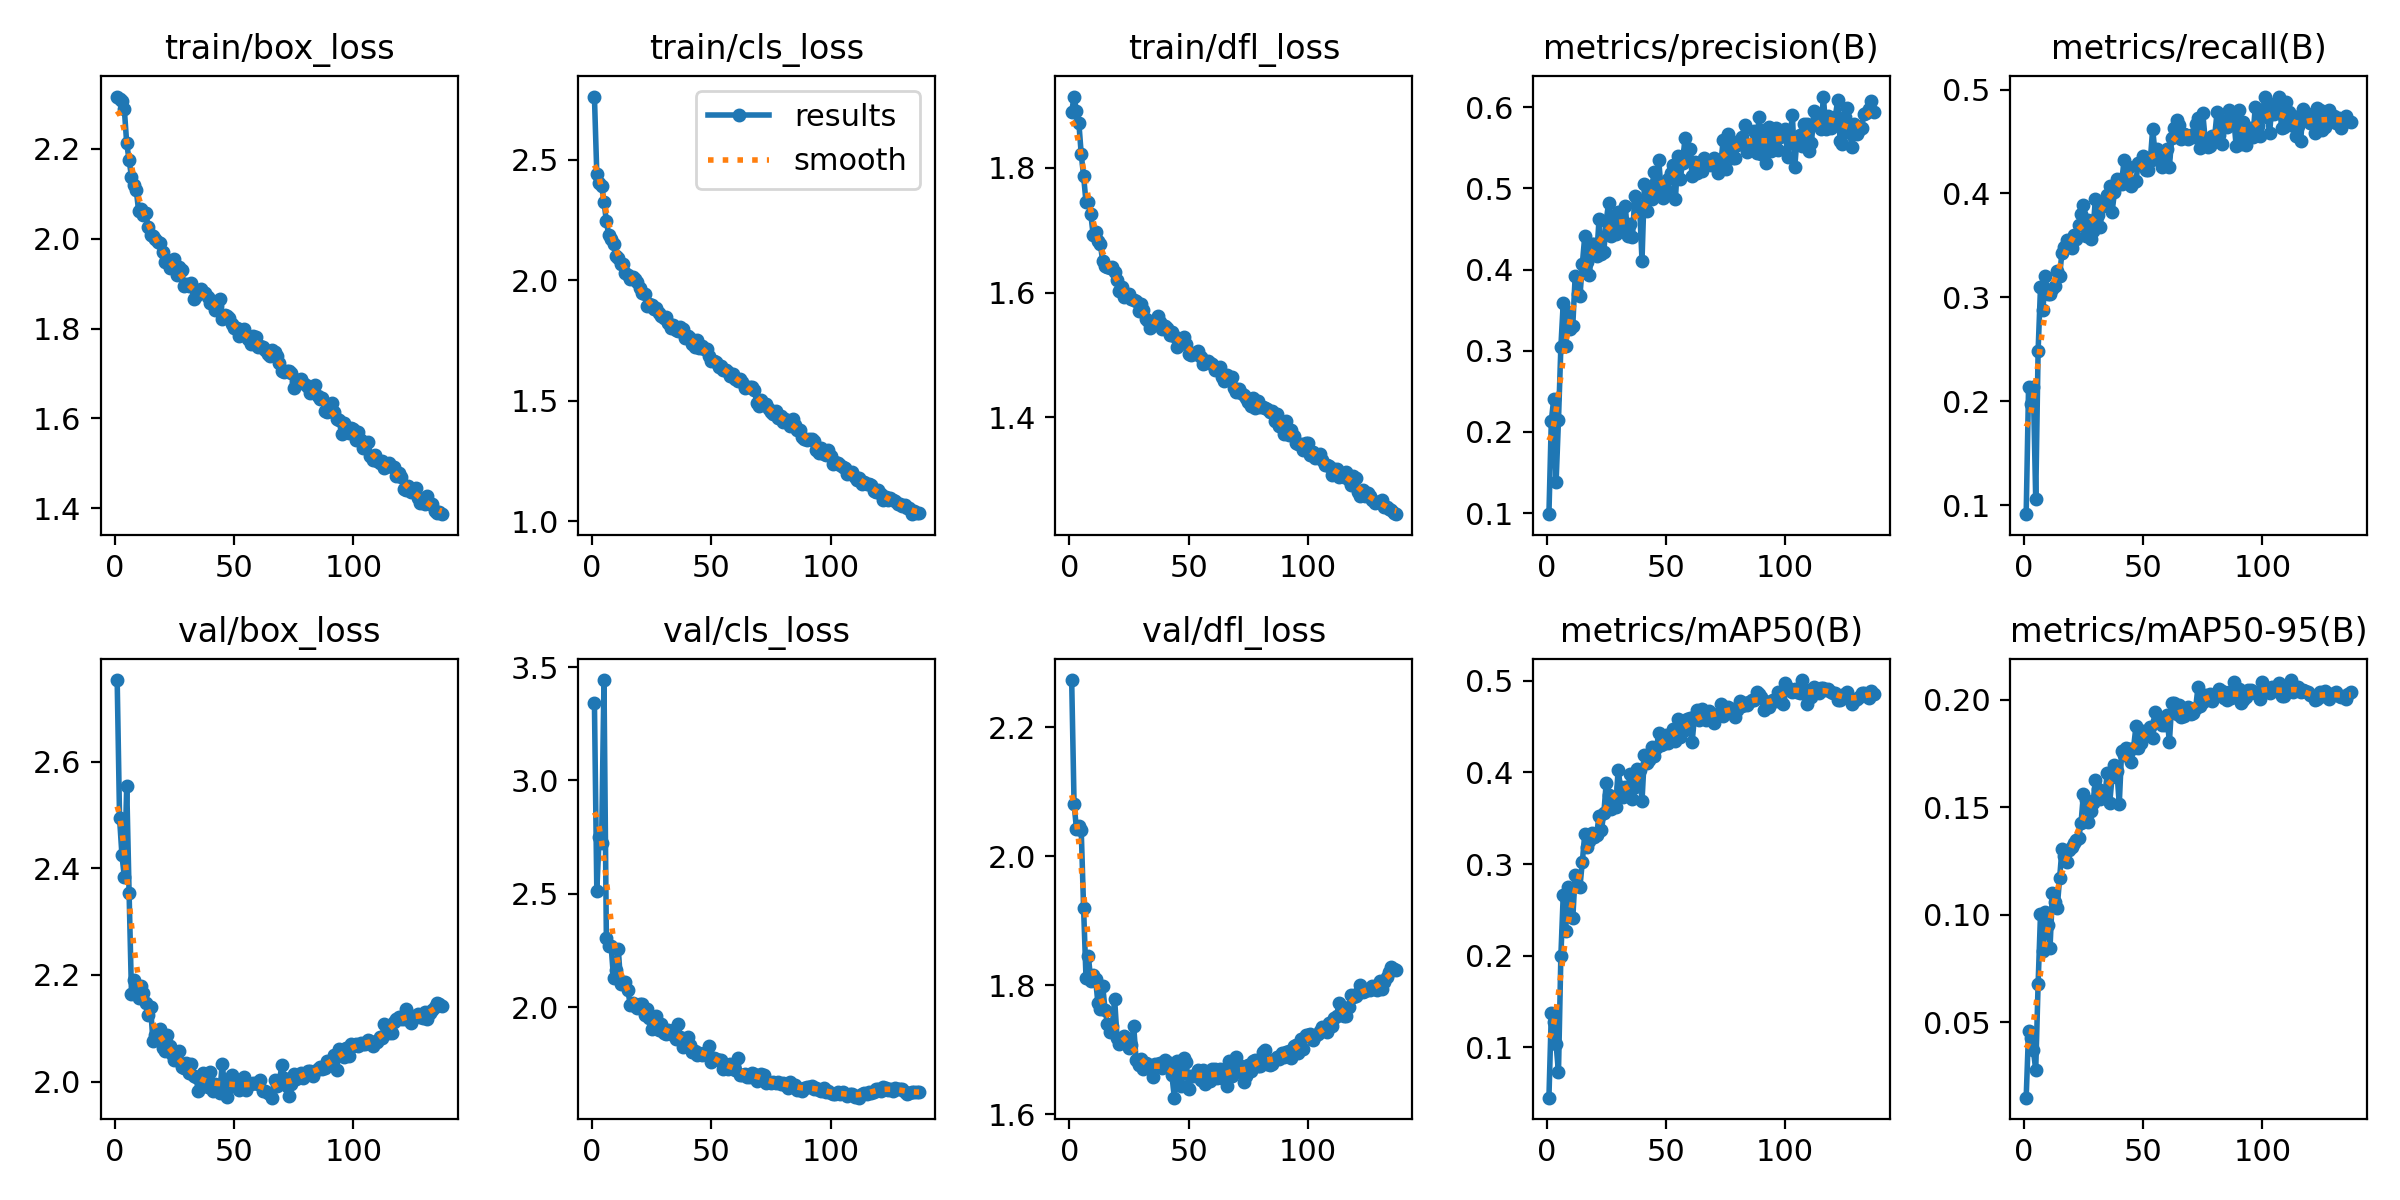

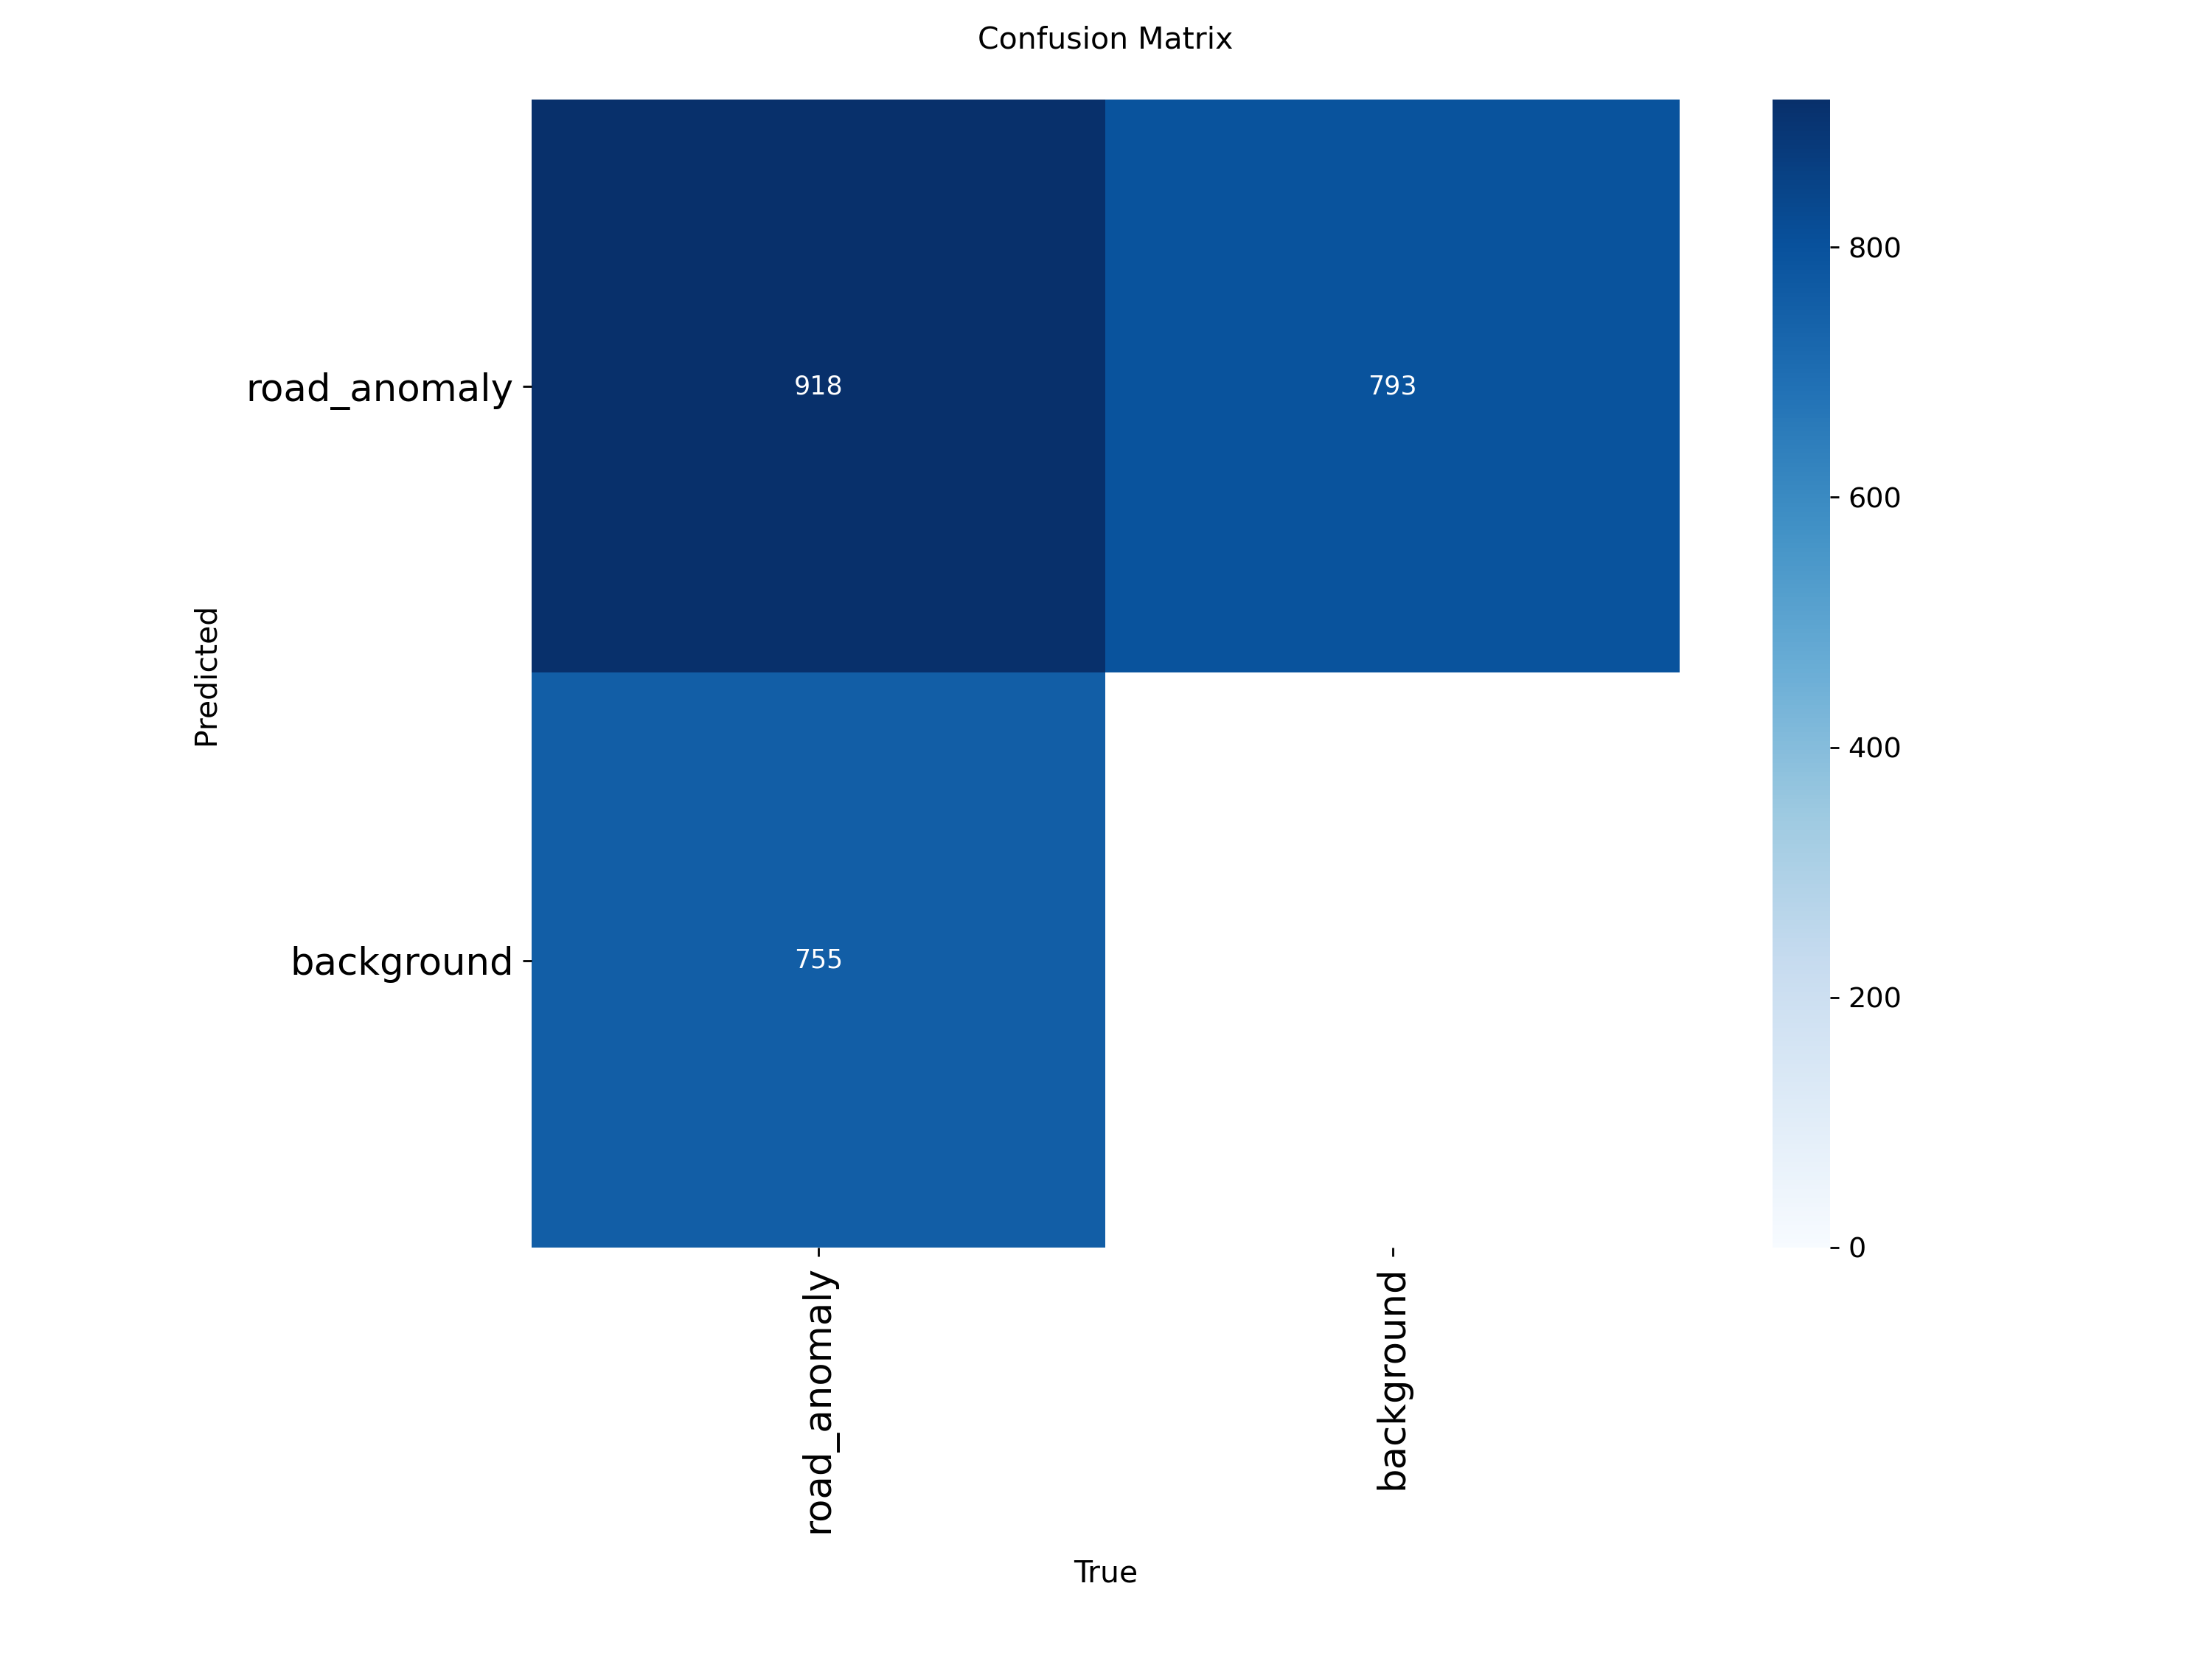

In [ ]:
from IPython.display import Image, display

RUN_DIR = Path("../../runs/detect/runs/yolo_rdd_binary/yolov8s_binary")

display(Image(filename=str(RUN_DIR / "results.png")))
display(Image(filename=str(RUN_DIR / "confusion_matrix.png")))

In [15]:
import pandas as pd

results_csv = RUN_DIR / "results.csv"
assert results_csv.exists(), "results.csv not found!"

df = pd.read_csv(results_csv)
df.tail()

epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
132    133  2270.11         1.40998         1.05280         1.25582   
133    134  2287.22         1.39313         1.02923         1.25225   
134    135  2304.20         1.38937         1.04403         1.25082   
135    136  2321.24         1.39205         1.03524         1.24547   
136    137  2338.35         1.38715         1.03220         1.24410   

     metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
132               0.59190            0.46324           0.48652   
133               0.59234            0.47221           0.48302   
134               0.59725            0.47460           0.48088   
135               0.60729            0.46981           0.48873   
136               0.59458            0.46922           0.48540   

     metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
132              0.20117       2.13402       1.62220       1.81246  0.000258   
133              0.20150       2.13969       1.62757       1.82070  0.000244   
134              0.20047       2.14845       1.62489       1.82817  0.000231   
135              0.20265       2.14610       1.62529       1.82620  0.000218   
136              0.20353       2.14253       1.62770       1.82340  0.000205   

       lr/pg1    lr/pg2  
132  0.000258  0.000258  
133  0.000244  0.000244  
134  0.000231  0.000231  
135  0.000218  0.000218  
136  0.000205  0.000205

In [16]:
final = df.iloc[-1]

print("Final metrics:")
print(f"Precision: {final['metrics/precision(B)']:.4f}")
print(f"Recall:    {final['metrics/recall(B)']:.4f}")
print(f"mAP@0.5:   {final['metrics/mAP50(B)']:.4f}")
print(f"mAP@0.5:0.95: {final['metrics/mAP50-95(B)']:.4f}")

Final metrics:
Precision: 0.5946
Recall:    0.4692
mAP@0.5:   0.4854
mAP@0.5:0.95: 0.2035


# Inference

In [ ]:
# Predict
from ultralytics import YOLO
model = YOLO("../../runs/detect/runs/yolo_rdd_binary/yolov8s_binary/weights/best.pt")

model.predict(
    source="../../datasets/yolo_rdd_binary/images/val",
    conf=0.2,
    save=True,
    project="../../runs/yolo_rdd_binary",
    name="predictions_val"
)



image 1/764 /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary/images/val/India_000010.jpg: 416x416 1 road_anomaly, 2.8ms
image 2/764 /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary/images/val/India_000027.jpg: 416x416 4 road_anomalys, 2.8ms
image 3/764 /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary/images/val/India_000052.jpg: 416x416 15 road_anomalys, 2.7ms
image 4/764 /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary/images/val/India_000054.jpg: 416x416 3 road_anomalys, 2.8ms
image 5/764 /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary/images/val/India_000057.jpg: 416x416 1 road_anomaly, 2.7ms
image 6/764 /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary/images/val/India_000071.jpg: 416x416 5 road_anomalys, 2.7ms
image 7/764 /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary/images/val/India_000090.jpg: 416x416 1 road_anomaly, 2.8ms
image 8/764 /home/saber/GitH

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'road_anomaly'}
 obb: None
 orig_img: array([[[233, 217, 204],
         [233, 217, 204],
         [233, 217, 204],
         ...,
         [191, 175, 163],
         [193, 177, 165],
         [204, 188, 176]],
 
        [[233, 217, 204],
         [233, 217, 204],
         [233, 217, 204],
         ...,
         [200, 184, 172],
         [196, 180, 168],
         [190, 174, 162]],
 
        [[233, 217, 204],
         [233, 217, 204],
         [233, 217, 204],
         ...,
         [206, 190, 178],
         [196, 180, 168],
         [177, 161, 149]],
 
        ...,
 
        [[ 86,  98, 110],
         [ 86,  98, 110],
         [ 86,  98, 110],
         ...,
         [ 41,  42,  33],
         [ 41,  42,  33],
         [ 41,  42,  33]],
 
        [[ 88,  97, 110],
         [ 88,  97, 110],
         [ 87,  96, 109],
         ...,
         [ 4

Total predicted images: 764


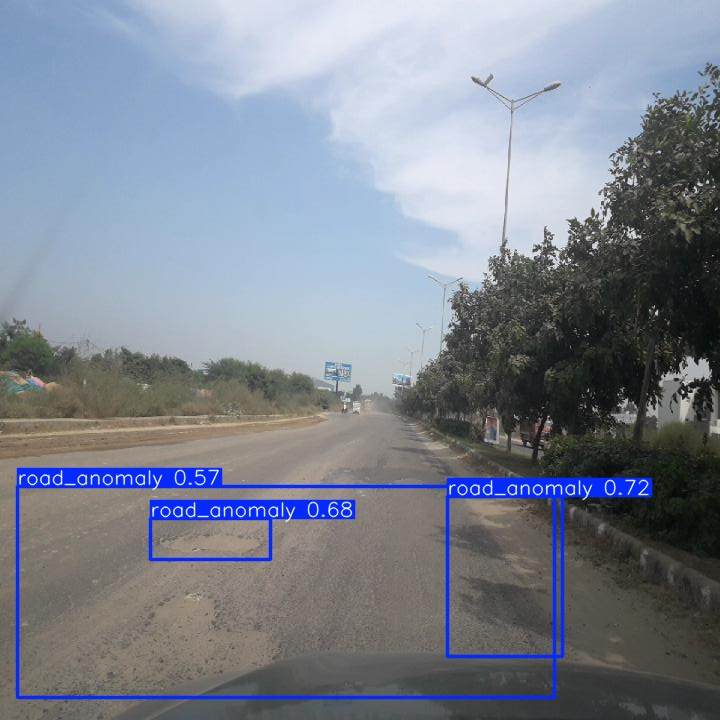

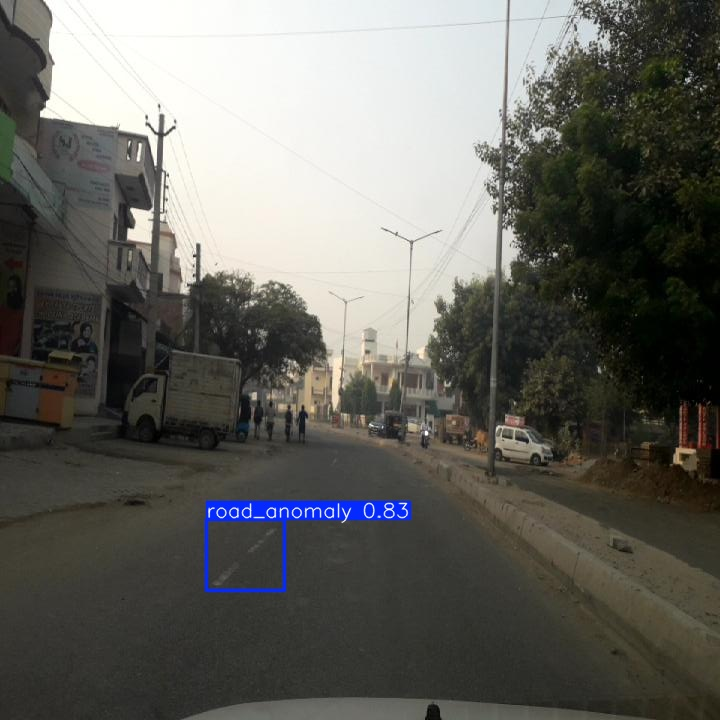

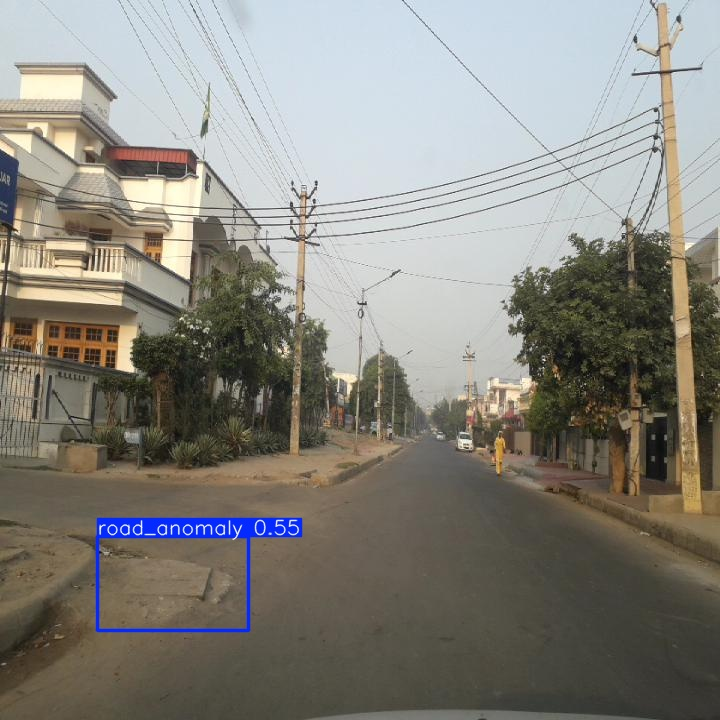

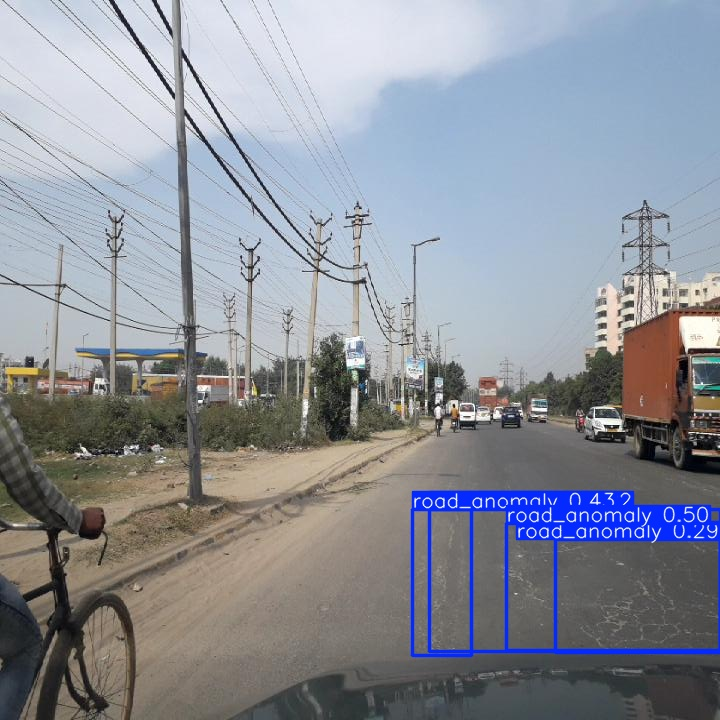

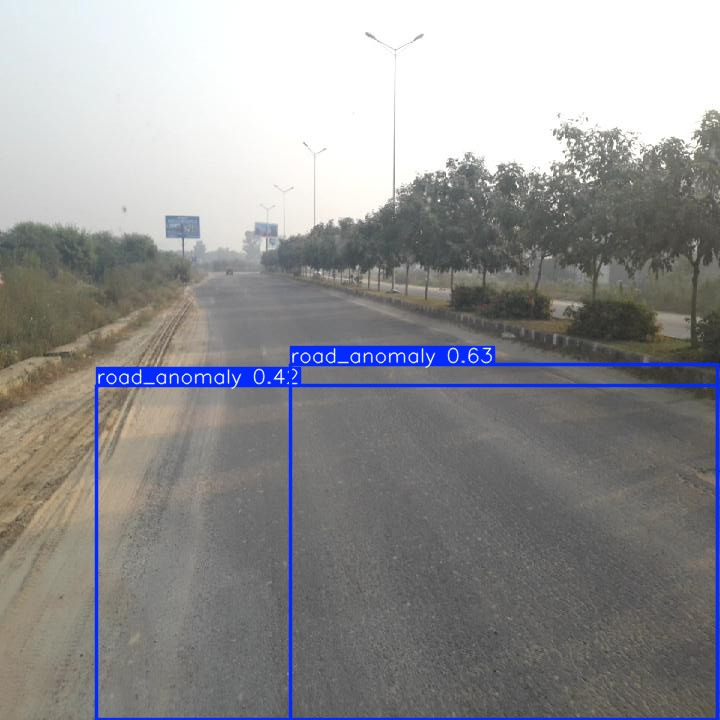

In [ ]:
from pathlib import Path
from IPython.display import Image, display
import random

PRED_DIR = Path("../../runs/detect/runs/yolo_rdd_binary/predictions_val")

assert PRED_DIR.exists(), "Prediction directory not found!"

images = list(PRED_DIR.glob("*.jpg"))
print(f"Total predicted images: {len(images)}")

for img_path in random.sample(images, 5):
    display(Image(filename=str(img_path)))


# Predictions on test set

In [ ]:
from ultralytics import YOLO

model = YOLO("../../runs/detect/runs/yolo_rdd_binary/yolov8s_binary/weights/best.pt")

model.predict(
    source="../../India/test/images",
    conf=0.2,
    save=True,
    project="../../runs/yolo_rdd_binary",
    name="predictions_test"
)


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1959 /home/saber/GitHub/road_anomaly_detection/India/test/images/India_000004.jpg: 416x416 1 road_anomaly, 5.3ms
image 2/1959 /home/saber/GitHub/road_anomaly_detection/India/test/images/India_000006.jpg: 416x416 2 road_anomalys, 3.4ms
image 3/1959 /home/saber/GitHub/road_anomaly_detection/India/test/images/India_000008.jpg: 416x416 1 road_anomaly, 4.0ms
image 4/1959 /home/saber/GitHub/road_anomaly_detection/India/test/images/India_000009.jpg: 416

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'road_anomaly'}
 obb: None
 orig_img: array([[[ 17,  17,  23],
         [ 18,  18,  24],
         [ 20,  21,  25],
         ...,
         [241, 241, 235],
         [241, 241, 235],
         [241, 241, 235]],
 
        [[ 13,  13,  19],
         [ 15,  15,  21],
         [ 17,  18,  22],
         ...,
         [241, 241, 235],
         [241, 241, 235],
         [241, 241, 235]],
 
        [[ 10,  10,  16],
         [ 12,  12,  18],
         [ 15,  16,  20],
         ...,
         [241, 241, 235],
         [241, 241, 235],
         [241, 241, 235]],
 
        ...,
 
        [[  6,   1,   2],
         [  6,   1,   2],
         [  6,   1,   2],
         ...,
         [  4,   2,   2],
         [  3,   1,   1],
         [  3,   1,   1]],
 
        [[  6,   1,   2],
         [  6,   1,   2],
         [  6,   1,   2],
         ...,
         [ 1

Total test images predicted: 1959


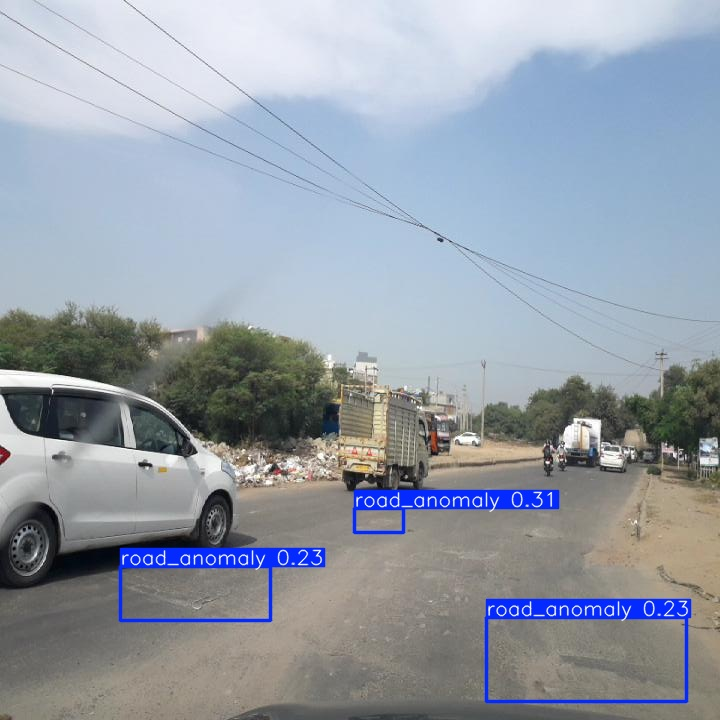

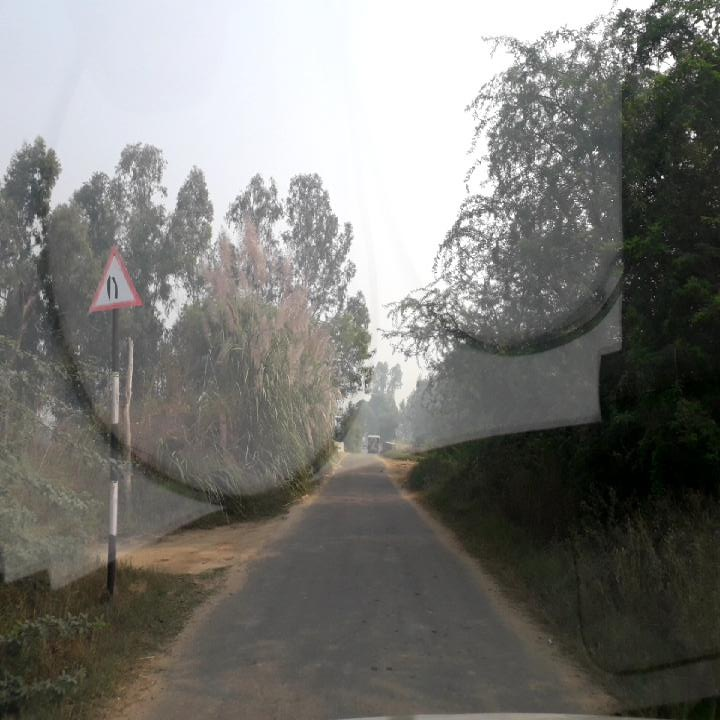

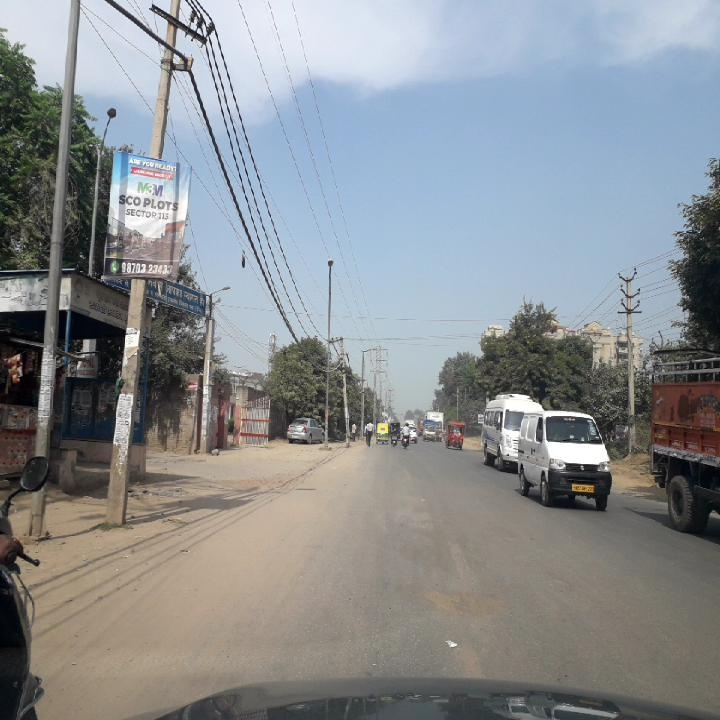

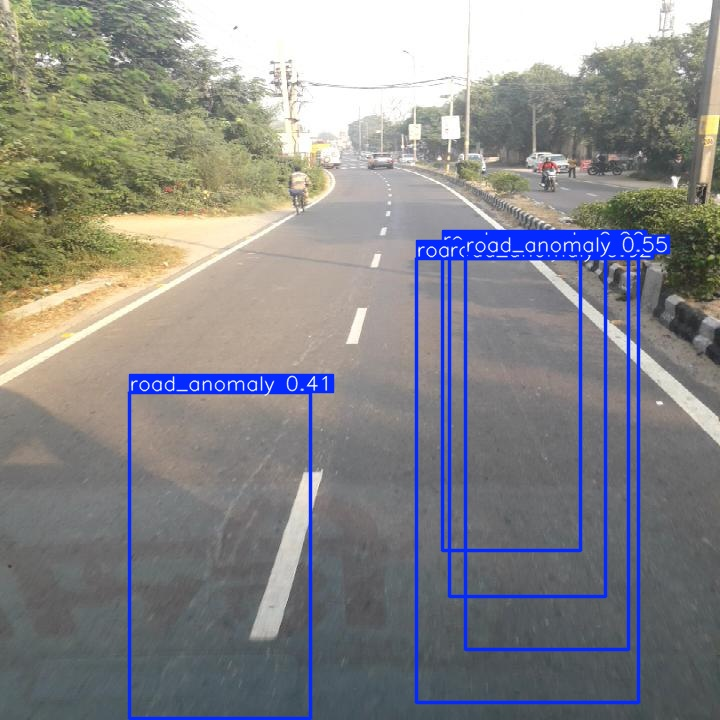

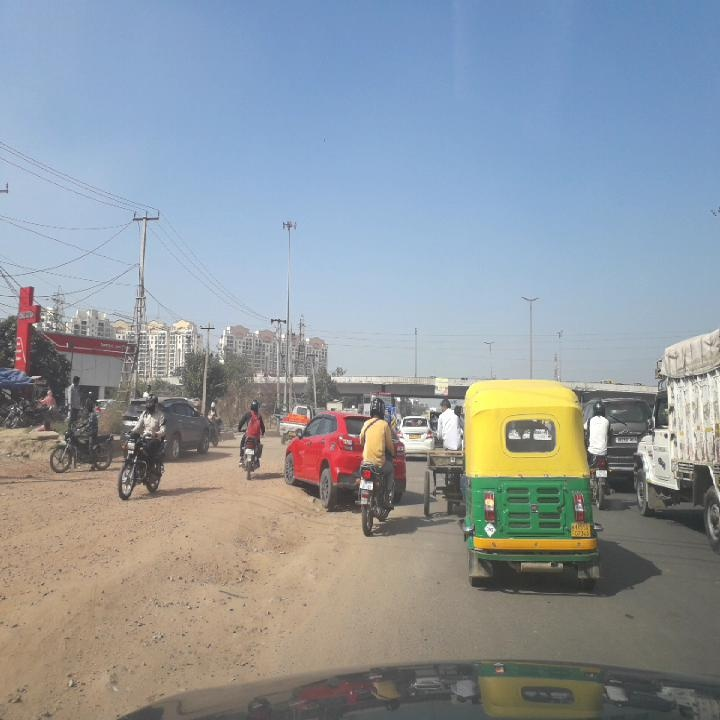

In [ ]:
from pathlib import Path
from IPython.display import Image, display
import random

PRED_TEST_DIR = Path("../../runs/detect/runs/yolo_rdd_binary/predictions_test")

images = list(PRED_TEST_DIR.glob("*.jpg"))
print(f"Total test images predicted: {len(images)}")

for img in random.sample(images, 5):
    display(Image(filename=str(img)))